In [3]:

import urllib
import xml.etree.ElementTree as ET
import urllib
import re
import io, random
import pandas as pd
import time
from datetime import datetime
from sklearn.svm import SVR
import datetime
from skmultiflow.meta import AdaptiveRandomForestRegressor
from skmultiflow.trees import HoeffdingTreeRegressor
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

In [4]:
df=pd.read_csv("merged_final.csv")

In [5]:
df.head()

,Unnamed: 0,DATE_TIME,PLANT_ID,SCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID.1,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2,2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
4,4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0


In [6]:
def pred_svr(x, y, x_test):
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    y_rbf = svr_rbf.fit(x, np.ravel(y,order='C'))
    return svr_rbf.predict(x_test)

def pred_rff(x, y, x_test):
    arf_reg = AdaptiveRandomForestRegressor(random_state=123456)
    arf_reg.fit(np.array(x), np.ravel(y,order='C'))
    return arf_reg.predict(x_test)
 
def pred_hoe(x, y, x_test):
    #arf_reg = HoeffdingTreeRegressor()
    arf_reg = DecisionTreeRegressor(random_state=0)
    arf_reg.fit(np.array(x), np.ravel(y,order='C'))
    return arf_reg.predict(x_test)

def algorithms_pred(df):
    x_total = df[["AMBIENT_TEMPERATURE","MODULE_TEMPERATURE","IRRADIATION"]].to_numpy().tolist()
    y_total = df[["DAILY_YIELD"]].to_numpy().tolist()
    x = x_total[:len(df)-1]
    y = y_total[:len(df)-1]
    x_test = x_total[len(df)-1:]
    y_test = y_total[len(df)-1:]
    y_pred_svr = pred_svr(x,y,x_test)
    y_pred_rff = pred_rff(x,y,x_test)
    y_pred_hoe = pred_hoe(x,y,x_test)
    y_pred_ensemb = (1/3)*np.add(np.add(y_pred_rff,y_pred_svr),y_pred_hoe)
    if(y_test!=0):
        MAPE_list.append([y_test[0][0],y_pred_svr[0]])
        MAPE_list2.append([y_test[0][0],y_pred_rff[0]])
        MAPE_list3.append([y_test[0][0],y_pred_hoe[0]])
        MAPE_list_ensemb.append([y_test[0][0],y_pred_ensemb[0]])
        
# def otherAlgorithm(df):
#     x_total = df[["AMBIENT_TEMPERATURE","MODULE_TEMPERATURE","IRRADIATION"]].to_numpy().tolist()
#     y_total = df[["DAILY_YIELD"]].to_numpy().tolist()
#     x = x_total[:len(df)-1]
#     y MAPE_list[:len(df)-1]
#     x_test = x_total[len(df)-1:]
#     y_test = y_total[len(df)-1:]
    
#     if(y_test!=0):
#         MAPE_list2.append([y_test[0][0],y_pred[0]])

In [7]:
def dataprocess(df,dt_start):
    dt_end=dt_start+datetime.timedelta(0,TrainingWindow*time_sampling)
    #print(dt_start,dt_end)
    #print(sensor_list)
    #df = df.set_index(['DATE_TIME'])
    #print(df.loc[dt_start:dt_end])
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
    mask = (df['DATE_TIME'] > dt_start) & (df['DATE_TIME'] <= dt_end)
    df_proc=df.loc[mask]
    for i in sensor_list:
        msk=(df_proc['SCE_KEY']==i[0])
        df_proc_sen=df_proc.loc[msk]
        algorithms_pred(df_proc_sen)
    
    

In [12]:
#constant parameters
TrainingWindow = 30   #window size is found from historical data
PredictionWindow = 3   #prediction window/prediction horizon
time_sampling = 900 #Should be equal to data refreshing time
sensor_list=df[["SCE_KEY"]].to_numpy().tolist()
sensor_list=sensor_list[0:20]
print(sensor_list)
#main function
if __name__ == '__main__':
    MAPE_list = list()
    MAPE_list2 = list()
    MAPE_list3 = list()
    MAPE_list_ensemb = list()
    date=datetime.datetime(2020, 5, 25, 6, 15)
    dataprocess(df,date)
    #print(MAPE_list)
    MAPE_npArray = np.array(MAPE_list)
    MAPE_npArray2 = np.array(MAPE_list2)
    MAPE_npArray3 = np.array(MAPE_list3)
    MAPE_npArray_ensemb = np.array(MAPE_list_ensemb)
    #print(MAPE_npArray[:,0])
    mape = np.mean(np.abs((MAPE_npArray[:,0] - MAPE_npArray[:,1])/MAPE_npArray[:,0]))*100
    mape2 = np.mean(np.abs((MAPE_npArray2[:,0] - MAPE_npArray2[:,1])/MAPE_npArray2[:,0]))*100
    mape3 = np.mean(np.abs((MAPE_npArray3[:,0] - MAPE_npArray3[:,1])/MAPE_npArray3[:,0]))*100
    mape_ensemb = np.mean(np.abs((MAPE_npArray_ensemb[:,0] - MAPE_npArray_ensemb[:,1])/MAPE_npArray_ensemb[:,0]))*100
    print("MAPE for amwr is: "+ str(mape))
    print("MAPE for rff is: "+ str(mape2))
    print("MAPE for decision trees is: "+ str(mape3))
    print("MAPE for ensemble is: "+ str(mape_ensemb))
    list1 = list()
    list1.append(mape)
    list1.append(mape2)
    list1.append(mape3)
    list1.append(mape_ensemb)

[['1BY6WEcLGh8j5v7'], ['1IF53ai7Xc0U56Y'], ['3PZuoBAID5Wc2HD'], ['7JYdWkrLSPkdwr4'], ['McdE0feGgRqW7Ca'], ['VHMLBKoKgIrUVDU'], ['WRmjgnKYAwPKWDb'], ['ZnxXDlPa8U1GXgE'], ['ZoEaEvLYb1n2sOq'], ['adLQvlD726eNBSB'], ['bvBOhCH3iADSZry'], ['iCRJl6heRkivqQ3'], ['ih0vzX44oOqAx2f'], ['pkci93gMrogZuBj'], ['rGa61gmuvPhdLxV'], ['sjndEbLyjtCKgGv'], ['uHbuxQJl8lW7ozc'], ['wCURE6d3bPkepu2'], ['z9Y9gH1T5YWrNuG'], ['zBIq5rxdHJRwDNY']]
MAPE for amwr is: 17.708557447865406
MAPE for rff is: 8.670288661931917
MAPE for decision trees is: 5.461580576707056
MAPE for ensemble is: 10.613475562168132


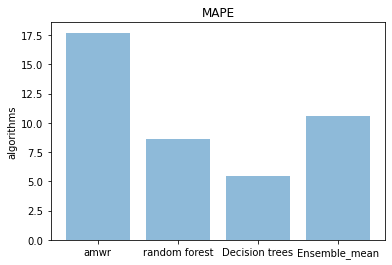

In [10]:
objects = ('amwr', 'random forest', 'Decision trees', 'Ensemble_mean')
y_pos = np.arange(len(objects))

plt.bar(y_pos, list1, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('algorithms')
plt.title('MAPE')

plt.show()